In [1]:
import numpy as np
from scipy import optimize
import scipy
from sklearn import base, metrics
import sklearn
from sklearn import linear_model
from sklearn.model_selection import KFold
from sklearn.utils.validation import check_X_y
from classifiers import *
from data_generation import *

In [ ]:
fig=plt.figure(figsize=(18, 16)

## Data Viz

In [2]:
## Number of dimensions and classes
k = 3

## Number of data points
n = 1000

In [6]:
X,y = generate_simplex_data(k,n)

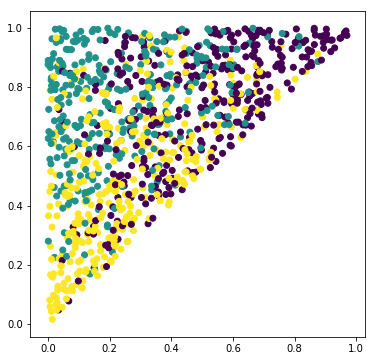

In [7]:
## Visualize Data Set
from matplotlib import pyplot as plt
fig=plt.figure(figsize=(6,6))
plt.scatter([X[:, 0]], [X[:, 1]], c=y.T)

## Metrics and Code Needed to Perform Tests

In [68]:
def weighted_absolute_loss(u, y, alpha):
    return np.mean((1 - alpha) * np.maximum((u - y), 0) + alpha * np.maximum((y - u), 0))

In [9]:
def compute_alpha_quantile(X, alpha):
    n = X.shape[0]
    y = np.zeros((n, 1))
    for i in range(0, n):
        curr_vec = X[i,:]
        
        if(alpha < curr_vec[0]):
            y[i, 0] = 0
        elif(alpha > curr_vec[-1]):
            y[i,0] = k - 1
        else:
            y[i,0] = np.argmax(curr_vec > alpha)
    return y

In [10]:
k = 3
n = 8
X, y = generate_simplex_data(k,n)
print(X)

[[0.13019177 0.3540841 ]
 [0.4710088  0.97739425]
 [0.36470663 0.83531626]
 [0.30839409 0.41010739]
 [0.30396325 0.97164506]
 [0.37598158 0.74498422]
 [0.36337256 0.37766119]
 [0.50606486 0.77505901]]


In [11]:
print(compute_alpha_quantile(X, 0.3))

[[1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]]


## Tests

In [21]:
k = 3
n = 1000
a1 = 0.3
a2 = 0.5
a3 = 0.75

X_train,y_train = generate_simplex_data(k,n)
y_train = y_train.astype(int)

X_test,y_test = generate_simplex_data(k,n)
y_quantiles1 = compute_alpha_quantile(X_test, a1).astype(int)
y_quantiles2 = compute_alpha_quantile(X_test, a2).astype(int)
y_quantiles3 = compute_alpha_quantile(X_test, a3).astype(int)

In [22]:
## Cross Validation for rbf and polynomial kernel
quantiles = [a1, a2, a3]


q_vals = [2, 3, 4, 5]
cum_q_error_AT = [0] * len(q_vals)
cum_q_error_IT = [0] * len(q_vals)
cum_q_error_Direct = [0] * len(q_vals)

gamma_vals = [10**(-1), 10**0, 10**1, 10**2]
cum_gamma_error_AT = [0] * len(gamma_vals)
cum_gamma_error_IT = [0] * len(gamma_vals)
cum_gamma_error_Direct = [0] * len(gamma_vals)

kf = KFold(n_splits=5)
kf.get_n_splits(X_train)
for train_index, test_index in kf.split(X_train):
    print('NEW SPLIT')
    curr_X_train, curr_X_test = X_train[train_index], X_train[test_index]
    curr_y_train, curr_y_test = y_train[train_index], y_train[test_index]
    
    for i, q in enumerate(q_vals):
        curr_K_train = sklearn.metrics.pairwise.polynomial_kernel(curr_X_train, curr_X_train, degree=q)
        curr_K_test  = sklearn.metrics.pairwise.polynomial_kernel(curr_X_test,  curr_X_train, degree=q)
        for a in quantiles:
            a_test_quantiles = compute_alpha_quantile(curr_K_test, a)
            clf1 = LogisticQuantileIT(gamma=a, alpha=1.)
            clf1.fit(curr_K_train, curr_y_train)
            lossIT = metrics.zero_one_loss(clf1.predict(curr_K_test), a_test_quantiles , normalize=False)
            cum_q_error_IT[i] += lossIT
            
            clf2 = LogisticQuantileAT(gamma=a, alpha=1.)
            clf2.fit(curr_K_train, curr_y_train)
            lossAT = metrics.zero_one_loss(clf2.predict(curr_K_test), a_test_quantiles , normalize=False)
            cum_q_error_AT[i] += lossAT
            
            clf3 = DirectQuantile(gamma=a, alpha=1.)
            clf3.fit(curr_K_train, curr_y_train)
            lossDirect = metrics.zero_one_loss(clf3.predict(curr_K_test), a_test_quantiles , normalize=False)
            cum_q_error_Direct[i] += lossDirect
            
        
    for j, ga in enumerate(gamma_vals):
        curr_K_train = sklearn.metrics.pairwise.rbf_kernel(curr_X_train, curr_X_train, gamma=ga)
        curr_K_test  = sklearn.metrics.pairwise.rbf_kernel(curr_X_test,  curr_X_train, gamma=ga)
        for a in quantiles:
            a_test_quantiles = compute_alpha_quantile(curr_K_test, a)
            clf1 = LogisticQuantileIT(gamma=a, alpha=1.)
            clf1.fit(curr_K_train, curr_y_train)
            lossIT = metrics.zero_one_loss(clf1.predict(curr_K_test), a_test_quantiles , normalize=False)
            cum_gamma_error_IT[j] += lossIT
            
            clf2 = LogisticQuantileAT(gamma=a, alpha=1.)
            clf2.fit(curr_K_train, curr_y_train)
            lossAT = metrics.zero_one_loss(clf2.predict(curr_K_test), a_test_quantiles , normalize=False)
            cum_gamma_error_AT[j] += lossAT
            
            clf3 = DirectQuantile(gamma=a, alpha=1.)
            clf3.fit(curr_K_train, curr_y_train)
            lossDirect = metrics.zero_one_loss(clf3.predict(curr_K_test), a_test_quantiles , normalize=False)
            cum_gamma_error_Direct[j] += lossDirect

NEW SPLIT


/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


NEW SPLIT
NEW SPLIT
NEW SPLIT
NEW SPLIT


In [23]:
print(cum_q_error_IT)
print(cum_q_error_AT)
print(cum_q_error_Direct)

print(cum_gamma_error_IT)
print(cum_gamma_error_AT)
print(cum_gamma_error_Direct)

## IT : q = 4, gamma=1
## AT: q = 5, gamma=1
## Direct: q = 3, gamma=1

[1831, 1832, 1818, 1824]
[2275, 2272, 2270, 2265]
[1979, 2000, 1919, 1885]
[1810, 1519, 1582, 1739]
[2262, 1976, 2055, 2182]
[1986, 1604, 1648, 2124]


## Linear Classifiers

In [28]:
k = 3
n = 1000
a = 0.3

X_train,y_train = generate_simplex_data(k,n)
y_train = y_train.astype(int)

X_test,y_test = generate_simplex_data(k,n)
y_quantiles = compute_alpha_quantile(X_test, a).astype(int)

In [69]:
def train_linear_classifiers(X_train, y_train, X_test, y_test, a):
    results = {}
    y_quantiles = compute_alpha_quantile(X_test, a).astype(int)
    clf5 = LogisticQuantileIT(gamma=a, alpha=1.)
    clf5.fit(X_train, y_train)
    abs_loss = weighted_absolute_loss(clf5.predict(X_test), y_test, a)
    zo_loss = metrics.zero_one_loss(clf5.predict(X_test), y_quantiles)
    print('Weighted Absolute Loss of LogisticQuantileIT, gamma=' + str(a) + ' %s' %
          abs_loss)
    print('0-1 Loss of LogisticQuantileIT, gamma=' + str(a) + ' %s' %
          zo_loss)
    results[clf5] = {'AbsLoss': abs_loss, 'ZoLoss': zo_loss}

    clf6 = LogisticQuantileAT(gamma=a, alpha=1.)
    clf6.fit(X_train, y_train)
    zo_loss = metrics.zero_one_loss(clf6.predict(X_test), y_quantiles)
    abs_loss = weighted_absolute_loss(clf6.predict(X_test), y_test, a)
    print('Weighted Absolute Loss of LogisticQuantileAT, gamma=' + str(a) + ' %s' %
          abs_loss)
    print('0-1 Loss of LogisticQuantileAT, gamma=' + str(a) + ' %s' %
          zo_loss)
    results[clf6] = {'AbsLoss': abs_loss, 'ZoLoss': zo_loss}
    
    clf7 = DirectQuantile(gamma=a, alpha=1.)
    clf7.fit(X_train, y_train)
    abs_loss = weighted_absolute_loss(clf7.predict(X_test), y_test, a)
    zo_loss = metrics.zero_one_loss(clf7.predict(X_test), y_quantiles)
    print('Weighted Absolute Loss of DirectQuantile, gamma=' + str(a) + ' %s' %
          abs_loss)
    print('0-1 Loss of DirectQuantile, gamma=' + str(a) + ' %s' %
          zo_loss)
    results[clf7] = {'AbsLoss': abs_loss, 'ZoLoss': zo_loss}
    return results

In [70]:
results_linear_a1 = train_linear_classifiers(X_train, y_train, X_test, y_test, a1)

results_linear_a2 = train_linear_classifiers(X_train, y_train, X_test, y_test, a2)

results_linear_a3 = train_linear_classifiers(X_train, y_train, X_test, y_test, a3)

/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Weighted Absolute Loss of LogisticQuantileIT, gamma=0.3 0.3363500000000001
0-1 Loss of LogisticQuantileIT, gamma=0.3 0.348
Weighted Absolute Loss of LogisticQuantileAT, gamma=0.3 0.32680500000000007
0-1 Loss of LogisticQuantileAT, gamma=0.3 0.20899999999999996
Weighted Absolute Loss of DirectQuantile, gamma=0.3 0.3075
0-1 Loss of DirectQuantile, gamma=0.3 0.516
Weighted Absolute Loss of LogisticQuantileIT, gamma=0.5 0.462665
0-1 Loss of LogisticQuantileIT, gamma=0.5 0.31000000000000005
Weighted Absolute Loss of LogisticQuantileAT, gamma=0.5 0.4066
0-1 Loss of LogisticQuantileAT, gamma=0.5 0.16900000000000004
Weighted Absolute Loss of DirectQuantile, gamma=0.5 0.3631
0-1 Loss of DirectQuantile, gamma=0.5 0.32699999999999996
Weighted Absolute Loss of LogisticQuantileIT, gamma=0.75 0.27272
0-1 Loss of LogisticQuantileIT, gamma=0.75 0.31699999999999995
Weighted Absolute Loss of LogisticQuantileAT, gamma=0.75 0.294905
0-1 Loss of LogisticQuantileAT, gamma=0.75 0.18000000000000005
Weighted A

In [26]:
results_linear_a1

{LogisticQuantileIT(alpha=1.0, gamma=0.3, max_iter=1000, verbose=0): {'AbsLoss': 0.7079999999999999,
  'ZoLoss': 0.348},
 LogisticQuantileAT(alpha=1.0, gamma=0.3, max_iter=1000, verbose=0): {'AbsLoss': 0.8051999999999999,
  'ZoLoss': 0.20899999999999996},
 DirectQuantile(alpha=1.0, gamma=0.3, max_iter=1000, verbose=0): {'AbsLoss': 0.5999999999999998,
  'ZoLoss': 0.516}}

### Plot Decision Boundary of Linear

In [64]:
curr = results_linear_a3
for clf in curr.keys():
    print(clf)    
    fig=plt.figure(figsize=(6,6))
    plt.scatter([X_test[:, 0]], [X_test[:, 1]], c=[clf.predict(X_test).T])
    plt.show()

LogisticQuantileIT(alpha=1.0, gamma=0.75, max_iter=1000, verbose=0)
AbsLoss 0.589
ZoLoss 0.31699999999999995
LogisticQuantileAT(alpha=1.0, gamma=0.75, max_iter=1000, verbose=0)
AbsLoss 0.7375
ZoLoss 0.18000000000000005
DirectQuantile(alpha=1.0, gamma=0.75, max_iter=1000, verbose=0)
AbsLoss 0.5225
ZoLoss 0.473


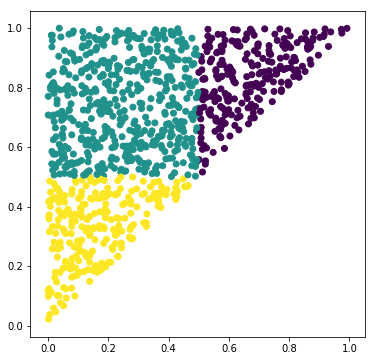

In [46]:
y_quantiles = compute_alpha_quantile(X_test, a2).astype(int)
fig=plt.figure(figsize=(6,6))
plt.scatter([X_test[:, 0]], [X_test[:, 1]], c=y_quantiles.T)

## Polynomial Classifiers

In [71]:
def train_polynomial_classifiers(X_train, y_train, X_test, y_test, a):
    ## From cross validation, IT -> q = 4, AT -> q = 5, Direct -> q = 3
    results = {}
    y_quantiles = compute_alpha_quantile(X_test, a).astype(int)
    
    K4_train = sklearn.metrics.pairwise.polynomial_kernel(X_train, X_train, degree=4)
    K4_test  = sklearn.metrics.pairwise.polynomial_kernel(X_test,  X_train, degree=4)
    clf5 = LogisticQuantileIT(gamma=a, alpha=1.)
    clf5.fit(K4_train, y_train)
    abs_loss = weighted_absolute_loss(clf5.predict(K4_test), y_test, a)
    zo_loss = metrics.zero_one_loss(clf5.predict(K4_test), y_quantiles)
    print('Weighted Absolute Loss of LogisticQuantileIT, gamma=' + str(a) + ' %s' %
          abs_loss)
    print('0-1 Loss of LogisticQuantileIT, gamma=' + str(a) + ' %s' %
          zo_loss)
    results[clf5] = {'AbsLoss': abs_loss, 'ZoLoss': zo_loss, 'TestSet': K4_test}

    K5_train = sklearn.metrics.pairwise.polynomial_kernel(X_train, X_train, degree=5)
    K5_test  = sklearn.metrics.pairwise.polynomial_kernel(X_test,  X_train, degree=5)
    clf6 = LogisticQuantileAT(gamma=a, alpha=1.)
    clf6.fit(K5_train, y_train)
    zo_loss = metrics.zero_one_loss(clf6.predict(K5_test), y_quantiles)
    abs_loss = weighted_absolute_loss(clf6.predict(K5_test), y_test, a)
    print('Weighted Absolute Loss of LogisticQuantileAT, gamma=' + str(a) + ' %s' %
          abs_loss)
    print('0-1 Loss of LogisticQuantileAT, gamma=' + str(a) + ' %s' %
          zo_loss)
    results[clf6] = {'AbsLoss': abs_loss, 'ZoLoss': zo_loss, 'TestSet': K5_test}
    
    
    K3_train = sklearn.metrics.pairwise.polynomial_kernel(X_train, X_train, degree=3)
    K3_test  = sklearn.metrics.pairwise.polynomial_kernel(X_test,  X_train, degree=3)
    clf7 = DirectQuantile(gamma=a, alpha=1.)
    clf7.fit(K3_train, y_train)
    abs_loss = weighted_absolute_loss(clf7.predict(K3_test), y_test, a)
    zo_loss = metrics.zero_one_loss(clf7.predict(K3_test), y_quantiles)
    print('Weighted Absolute Loss of DirectQuantile, gamma=' + str(a) + ' %s' %
          abs_loss)
    print('0-1 Loss of DirectQuantile, gamma=' + str(a) + ' %s' %
          zo_loss)
    results[clf7] = {'AbsLoss': abs_loss, 'ZoLoss': zo_loss, 'TestSet': K3_test}
    return results

In [72]:
results_polynomial_a1 = train_polynomial_classifiers(X_train, y_train, X_test, y_test, a1)

results_polynomial_a2 = train_polynomial_classifiers(X_train, y_train, X_test, y_test, a2)

results_polynomial_a3 = train_polynomial_classifiers(X_train, y_train, X_test, y_test, a3)

/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Weighted Absolute Loss of LogisticQuantileIT, gamma=0.3 0.34101
0-1 Loss of LogisticQuantileIT, gamma=0.3 0.32399999999999995
Weighted Absolute Loss of LogisticQuantileAT, gamma=0.3 0.33004500000000014
0-1 Loss of LogisticQuantileAT, gamma=0.3 0.20299999999999996
Weighted Absolute Loss of DirectQuantile, gamma=0.3 0.3075
0-1 Loss of DirectQuantile, gamma=0.3 0.516
Weighted Absolute Loss of LogisticQuantileIT, gamma=0.5 0.455675
0-1 Loss of LogisticQuantileIT, gamma=0.5 0.268
Weighted Absolute Loss of LogisticQuantileAT, gamma=0.5 0.407375
0-1 Loss of LogisticQuantileAT, gamma=0.5 0.15600000000000003
Weighted Absolute Loss of DirectQuantile, gamma=0.5 0.36058
0-1 Loss of DirectQuantile, gamma=0.5 0.33699999999999997
Weighted Absolute Loss of LogisticQuantileIT, gamma=0.75 0.29826
0-1 Loss of LogisticQuantileIT, gamma=0.75 0.28800000000000003
Weighted Absolute Loss of LogisticQuantileAT, gamma=0.75 0.31383
0-1 Loss of LogisticQuantileAT, gamma=0.75 0.137
Weighted Absolute Loss of DirectQ

## Visualization of Boundaries

In [67]:
curr = results_polynomial_a3
for clf in curr.keys():
    print(clf)    
#     fig=plt.figure(figsize=(6,6))
#     plt.scatter([X_test[:, 0]], [X_test[:, 1]], c=[clf.predict(results_polynomial_a3[clf]['TestSet']).T])
#     plt.show()
    print('AbsLoss ' + str(curr[clf]['AbsLoss']))
    print('ZoLoss ' + str(curr[clf]['ZoLoss']))

LogisticQuantileIT(alpha=1.0, gamma=0.75, max_iter=1000, verbose=0)
AbsLoss 0.6335
ZoLoss 0.28800000000000003
LogisticQuantileAT(alpha=1.0, gamma=0.75, max_iter=1000, verbose=0)
AbsLoss 0.756
ZoLoss 0.137
DirectQuantile(alpha=1.0, gamma=0.75, max_iter=1000, verbose=0)
AbsLoss 0.5
ZoLoss 0.42800000000000005


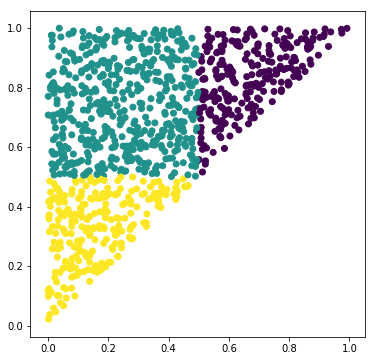

In [48]:
y_quantiles = compute_alpha_quantile(X_test, a2).astype(int)
fig=plt.figure(figsize=(6,6))
plt.scatter([X_test[:, 0]], [X_test[:, 1]], c=y_quantiles.T)

## RBF Kernel

In [78]:
def train_rbf_classifiers(X_train, y_train, X_test, y_test, a):
    ## From cross validation, all gammas are 1
    results = {}
    y_quantiles = compute_alpha_quantile(X_test, a).astype(int)
    
    gam = 10
    reg = 0.02
    K_train = sklearn.metrics.pairwise.rbf_kernel(X_train, X_train, gamma=gam)
    K_test  = sklearn.metrics.pairwise.rbf_kernel(X_test,  X_train, gamma=gam)
    

    clf5 = LogisticQuantileIT(gamma=a, alpha=reg)
    clf5.fit(K_train, y_train)
    abs_loss = weighted_absolute_loss(clf5.predict(K_test), y_test, a)
    zo_loss = metrics.zero_one_loss(clf5.predict(K_test), y_quantiles)
    print('Weighted Absolute Loss of LogisticQuantileIT, gamma=' + str(a) + ' %s' %
          abs_loss)
    print('0-1 Loss of LogisticQuantileIT, gamma=' + str(a) + ' %s' %
          zo_loss)
    results[clf5] = {'AbsLoss': abs_loss, 'ZoLoss': zo_loss, 'TestSet': K_test}

    clf6 = LogisticQuantileAT(gamma=a, alpha=reg)
    clf6.fit(K_train, y_train)
    zo_loss = metrics.zero_one_loss(clf6.predict(K_test), y_quantiles)
    abs_loss = weighted_absolute_loss(clf6.predict(K_test), y_test, a)
    print('Weighted Absolute Loss of LogisticQuantileAT, gamma=' + str(a) + ' %s' %
          abs_loss)
    print('0-1 Loss of LogisticQuantileAT, gamma=' + str(a) + ' %s' %
          zo_loss)
    results[clf6] = {'AbsLoss': abs_loss, 'ZoLoss': zo_loss, 'TestSet': K_test}
    
    
    clf7 = DirectQuantile(gamma=a, alpha=reg)
    clf7.fit(K_train, y_train)
    abs_loss = weighted_absolute_loss(clf7.predict(K_test), y_test, a)
    zo_loss = metrics.zero_one_loss(clf7.predict(K_test), y_quantiles)
    print('Weighted Absolute Loss of DirectQuantile, gamma=' + str(a) + ' %s' %
          abs_loss)
    print('0-1 Loss of DirectQuantile, gamma=' + str(a) + ' %s' %
          zo_loss)
    results[clf7] = {'AbsLoss': abs_loss, 'ZoLoss': zo_loss, 'TestSet': K_test}
    return results

In [79]:
results_rbf_a1 = train_rbf_classifiers(X_train, y_train, X_test, y_test, a1)

results_rbf_a2 = train_rbf_classifiers(X_train, y_train, X_test, y_test, a2)

results_rbf_a3 = train_rbf_classifiers(X_train, y_train, X_test, y_test, a3)

/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Weighted Absolute Loss of LogisticQuantileIT, gamma=0.3 0.33455999999999997
0-1 Loss of LogisticQuantileIT, gamma=0.3 0.32099999999999995
Weighted Absolute Loss of LogisticQuantileAT, gamma=0.3 0.33032000000000006
0-1 Loss of LogisticQuantileAT, gamma=0.3 0.20399999999999996
Weighted Absolute Loss of DirectQuantile, gamma=0.3 0.3075
0-1 Loss of DirectQuantile, gamma=0.3 0.516
Weighted Absolute Loss of LogisticQuantileIT, gamma=0.5 0.458345
0-1 Loss of LogisticQuantileIT, gamma=0.5 0.30800000000000005
Weighted Absolute Loss of LogisticQuantileAT, gamma=0.5 0.406445
0-1 Loss of LogisticQuantileAT, gamma=0.5 0.14800000000000002
Weighted Absolute Loss of DirectQuantile, gamma=0.5 0.481975
0-1 Loss of DirectQuantile, gamma=0.5 0.402
Weighted Absolute Loss of LogisticQuantileIT, gamma=0.75 0.30271
0-1 Loss of LogisticQuantileIT, gamma=0.75 0.29900000000000004
Weighted Absolute Loss of LogisticQuantileAT, gamma=0.75 0.32014
0-1 Loss of LogisticQuantileAT, gamma=0.75 0.15700000000000003
Weight

### Plot Results

LogisticQuantileIT(alpha=0.02, gamma=0.75, max_iter=1000, verbose=0)


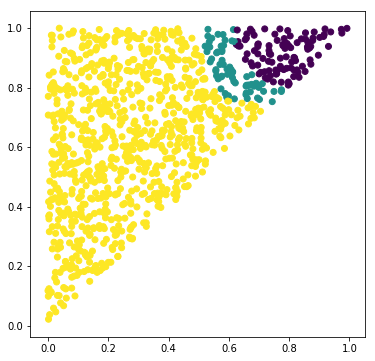

LogisticQuantileAT(alpha=0.02, gamma=0.75, max_iter=1000, verbose=0)


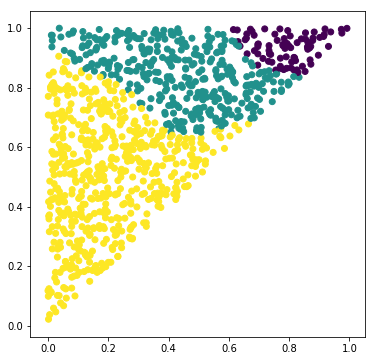

DirectQuantile(alpha=0.02, gamma=0.75, max_iter=1000, verbose=0)


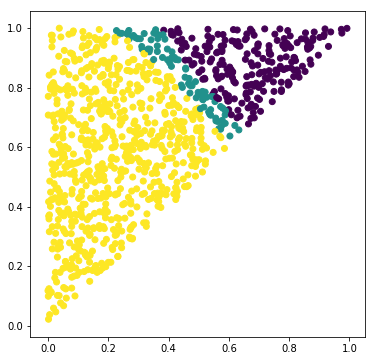

In [80]:
for clf in results_rbf_a3.keys():
    print(clf)    
    fig=plt.figure(figsize=(6,6))
    plt.scatter([X_test[:, 0]], [X_test[:, 1]], c=[clf.predict(results_rbf_a3[clf]['TestSet']).T])
    plt.show()

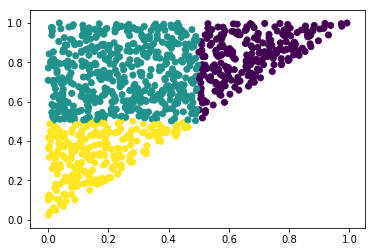

In [38]:
y_quantiles = compute_alpha_quantile(X_test, a2).astype(int)
plt.scatter([X_test[:, 0]], [X_test[:, 1]], c=y_quantiles.T)